• Python 실습

▪ 추가 개인 실습 (1시간 소요)

▶ 주어진 csv 파일을 읽어온 후 분류 Task를 진행하세요.

1. mushrooms.csv를 읽어온 후 df 변수로 저장하세요.
2. “class” 피처 Series를 y변수에 저장하고, 나머지 피처들을 x변수에 저장하세요.
3. x의 모든 피처들에 One-Hot Encoding을 적용하신 후, 결과 값들을 다시 x에 저장하세요.
4. y의 데이터에 One-Hot Encoding을 적용하신 후, 결과 값들을 다시 y에 저장하세요.
5. x와 y를 훈련 및 시험 데이터 셋으로 나누세요. (Scikit-Learn의 train_test_split 사용)
- test_size → 0.2
- random_state → 42
6. Seed를 42로 고정한 후 다음과 같은 인공신경망을 만드세요.

입력 → 16 노드 → 32 노드 → 16 노드 → 출력 (활성화 함수 → ReLU)

7. 다음과 같은 하이퍼파라미터를 사용하여 모델을 훈련하세요.

[ Optimizer → Adam | Learning Rate → 1e-2 | Batch Size → 32 | Epoch → 200 ]

8. 훈련 과정에서 얻은 Training Loss와 Training Accuracy를 시각화하세요.

9. 훈련된 모델 및 시험 데이터 셋을 사용하여 모든 정량적 지표를 출력하세요.

10. 모든 Process를 모델의 구조, 활성화 함수, 그리고 하이퍼파라미터를 바꾸어 가면서 정확도를 높여보세요.

In [49]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [50]:
torch.manual_seed(42)
np.random.seed(42)

In [51]:
df = pd.read_csv('/content/mushrooms.csv')

In [52]:
y = df['class']
x = df.drop(columns=['class'])

In [53]:
x = pd.get_dummies(x)
y = pd.get_dummies(y)  # e,p → 2개 컬럼

In [54]:
x = x.values
y = y.values

In [55]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [56]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [57]:
batch_size = 32
train_ds = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [58]:
class CustomMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CustomMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim)
        )

    def forward(self, x):
        return self.net(x)

In [59]:
model = CustomMLP(input_dim=x_train.shape[1], output_dim=y_train.shape[1])
print(model)

CustomMLP(
  (net): Sequential(
    (0): Linear(in_features=117, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [60]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [61]:
num_epochs = 200

In [62]:
train_losses = []
train_accs = []

In [63]:
for epoch in range(num_epochs):
    epoch_loss = 0.0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        outputs = model(batch_x)
        outputs = torch.sigmoid(outputs)  # BCELoss 위한 Sigmoid

        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * batch_x.size(0)

        # Accuracy 계산
        predicted = (outputs > 0.5).float()
        correct += (predicted == batch_y).float().sum().item()
        total += batch_y.numel()

    epoch_loss /= len(train_loader.dataset)
    acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(acc)

    if (epoch+1) % 20 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} | Accuracy: {acc:.4f}")


Epoch [1/200] Loss: 0.0614 | Accuracy: 0.9748
Epoch [20/200] Loss: 0.0000 | Accuracy: 1.0000
Epoch [40/200] Loss: 0.0000 | Accuracy: 1.0000
Epoch [60/200] Loss: 0.0000 | Accuracy: 1.0000
Epoch [80/200] Loss: 0.0000 | Accuracy: 1.0000
Epoch [100/200] Loss: 0.0000 | Accuracy: 1.0000
Epoch [120/200] Loss: 0.0000 | Accuracy: 1.0000
Epoch [140/200] Loss: 0.0000 | Accuracy: 1.0000
Epoch [160/200] Loss: 0.0000 | Accuracy: 1.0000
Epoch [180/200] Loss: 0.0000 | Accuracy: 1.0000
Epoch [200/200] Loss: 0.0000 | Accuracy: 1.0000


Text(0.5, 1.0, 'Training Loss')

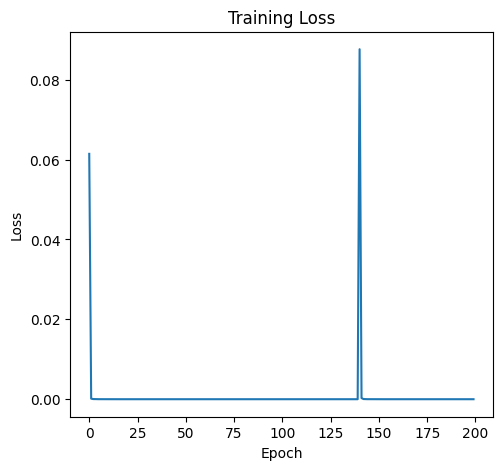

In [65]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

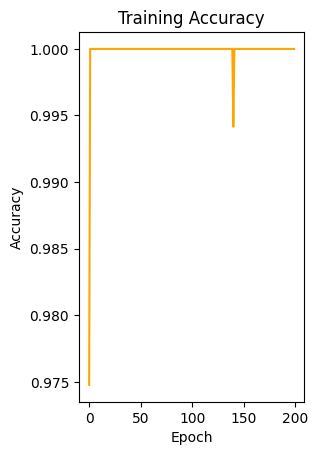

In [66]:
plt.subplot(1,2,2)
plt.plot(train_accs, label='Train Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.show()

In [67]:
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    outputs = torch.sigmoid(outputs)
    predicted = (outputs > 0.5).float()

    # 이진일 때는 한 열만 비교
    correct = (predicted == y_test_tensor).float().sum().item()
    total = y_test_tensor.numel()
    test_acc = correct / total

    test_loss = criterion(outputs, y_test_tensor).item()

print(f"[Test] Loss: {test_loss:.4f} | Accuracy: {test_acc:.4f}")

[Test] Loss: 0.0000 | Accuracy: 1.0000
